# 1K2F G-ADSA Analysis

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of a proprietary, difunctional polyol from Dow Chemical with molecular weight ~1000 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from June 12-17, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 30.5 C.

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit
import dataproc

from importlib import reload
reload(dataproc)

# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/'
# list of data files for ADSA generated from videos of a pendant drop
adsa_file_list = ['20190612_0614_1k2f_adsa_data.csv', '20190614_0617_1k2f_adsa_data.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../../EXPERIMENTS/Italy/data/gravimetry/1k2f-TRD-061219-1804.csv'
# file path to save results
save_file_path = '../../EXPERIMENTS/Italy/data/1k2f.csv'
save_plot_path = '../../EXPERIMENTS/Italy/data/1k2f_w_gas.pdf' # if '', plot not saved
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 6/12 6:05:58pm; adsa video 1 6/12 6:16pm, adsa video2 6/14 7:02pm
adsa_t0_list = [3600*25 + 60*8 + 2, 24*3600*2 + 60*56 + 2]
# number of measurements to average for surface tension and volume readings
n_adsa = 3

# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.686
# volume of drop in vacuum; if not available in video, input initial drop volume [uL]; o/w put 0
v_drop_0_manual = 3.332 
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS) [g/mL]
rho_samp_atm = 1.02 
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2675 # measured by Maria Rosaria Di Caprio @ 35 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
                       5000, 5500, 4650, 3900, 3150, 2400, 1650, 900, 700, 480, 
                       280, 230, 180, 130, 80])
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
dp_desorp = 700 # decrease in pressure during desorption [kPa]
di_desorp = 10 # duration of desorption step [# of measurements]

# CONSTANTS
# atmospheric pressure [kPa]
P_ATM = 101.3

## Load Data

Next we load the data from gravimetry and ADSA that we wish to process.

In [27]:
# initialize list to store interfacial tension measurements [mN/m]
if_tension = np.array([])
# also store drop volume measurements [uL]
drop_vol = np.array([])
# record time
t_adsa = np.array([])

# extract data from all data files for the pendant drop (ADSA)
for i in range(len(adsa_file_list)):
    adsa_file = adsa_file_list[i]
    df_adsa = pd.read_csv(adsa_folder + adsa_file, header=1)
    if_tension = np.concatenate((if_tension, df_adsa['IFT'].values))
    drop_vol = np.concatenate((drop_vol, df_adsa['PndVol'].values))
    t_adsa = np.concatenate((t_adsa, df_adsa['Secs.1'].values + adsa_t0_list[i]))

# load rubotherm data and process
df = pd.read_csv(grav_file_path, header=3)
# Extract time in terms of seconds after start
date_raw = df['DATE'].values
time_raw = df['TIME'].values
t_grav = dataproc.convert_time(date_raw, time_raw)
# shift time so initial time is zero to match interfacial tension time
t_grav -= t_grav[0]

# load rubotherm data in sync with time
br_arr = df['WEITGHT(g)'].values
bp_arr = df['BALANCE POSITION'].values
p_arr = df['Now Pressure(kPa)'].values

# initialize data frame to store data
df_meas = pd.DataFrame(columns=['p [kPa]', 'zero [g]', 'zero std [g]', 'mp1 [g]',
                        'mp1 std [g]', 'mp2 [g]', 'mp2 std [g]', 'if tension [mN/m]',
                        'if tension std [mN/m]', 'drop volume [uL]', 
                        'drop volume std [uL]'])
df_meas['p [kPa]'] = p_set_arr

## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 0 kPa.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Interfacial tension = nan mN/m.
Drop volume = nan uL.
Pressure = 500 kPa.


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Interfacial tension = 22.836667 mN/m.
Drop volume = 3.345000 uL.
Pressure = 1000 kPa.
Interfacial tension = 21.990000 mN/m.
Drop volume = 3.358333 uL.
Pressure = 1500 kPa.
Interfacial tension = 20.763333 mN/m.
Drop volume = 3.417000 uL.
Pressure = 2000 kPa.
Interfacial tension = 19.783333 mN/m.
Drop volume = 3.470333 uL.
Pressure = 2500 kPa.
Interfacial tension = 18.736667 mN/m.
Drop volume = 3.535667 uL.
Pressure = 3000 kPa.
Interfacial tension = 17.740000 mN/m.
Drop volume = 3.630667 uL.
Pressure = 3500 kPa.
Interfacial tension = 16.606667 mN/m.
Drop volume = 3.688000 uL.
Pressure = 4000 kPa.
Interfacial tension = 15.370000 mN/m.
Drop volume = 3.737000 uL.
Pressure = 4500 kPa.
Interfacial tension = 13.850000 mN/m.
Drop volume = 3.856000 uL.
Pressure = 5000 kPa.
Interfacial tension = 12.563333 mN/m.
Drop volume = 4.010333 uL.
Pressure = 5500 kPa.
Interfacial tension = 11.553333 mN/m.
Drop volume = 4.021000 uL.
Pressure = 4650 kPa.
Interfacial tension = 13.636667 mN/m.
Drop volume = 3.

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Interfacial tension = 23.160000 mN/m.
Drop volume = 3.342000 uL.
Pressure = 230 kPa.
Interfacial tension = 23.253333 mN/m.
Drop volume = 3.323000 uL.
Pressure = 180 kPa.
Interfacial tension = 23.353333 mN/m.
Drop volume = 3.306333 uL.
Pressure = 130 kPa.
Interfacial tension = 22.803333 mN/m.
Drop volume = 3.283000 uL.
Pressure = 80 kPa.
Interfacial tension = 22.870000 mN/m.
Drop volume = 3.286000 uL.


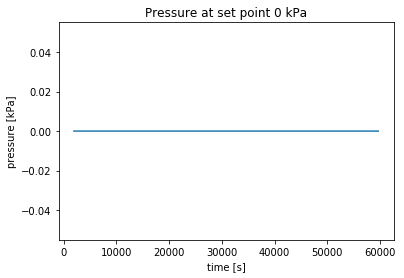

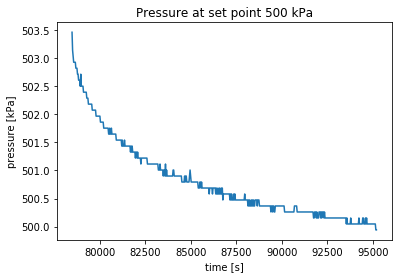

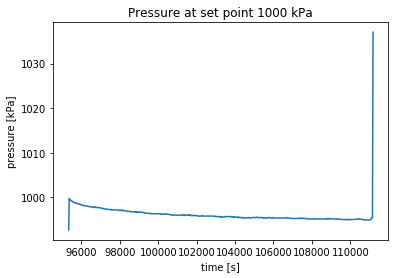

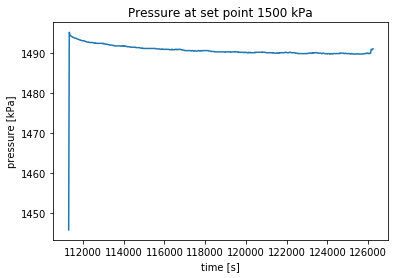

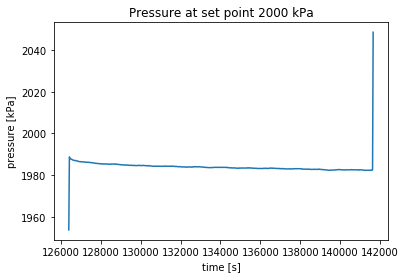

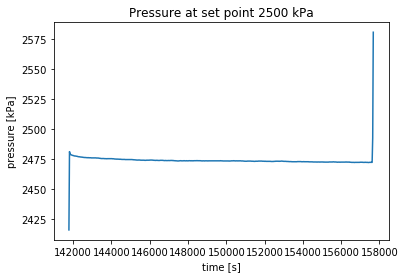

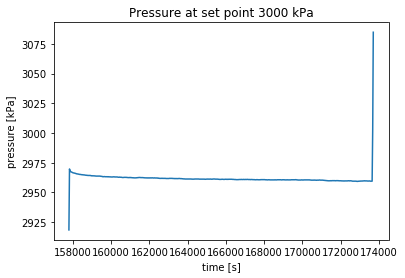

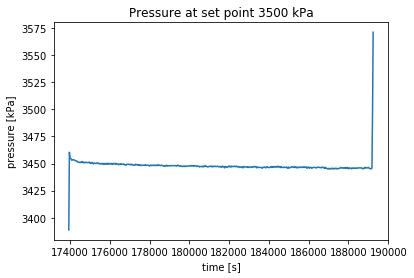

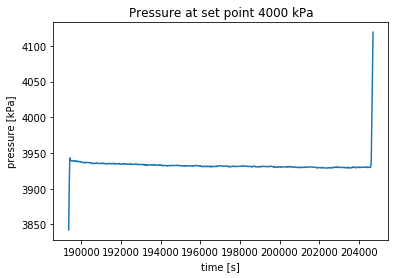

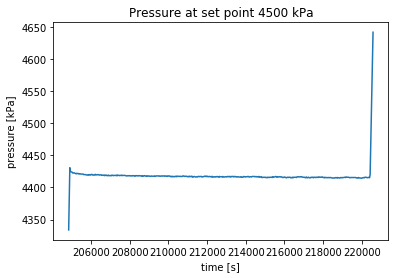

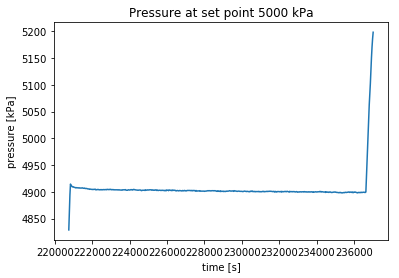

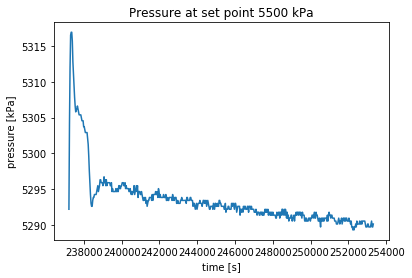

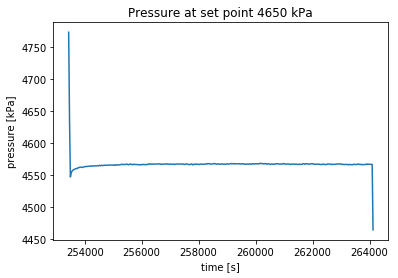

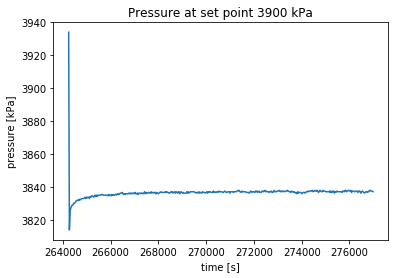

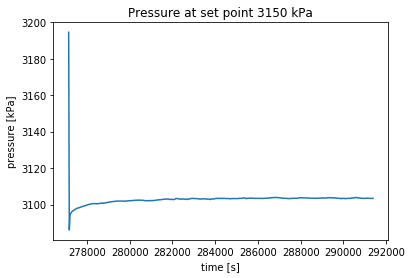

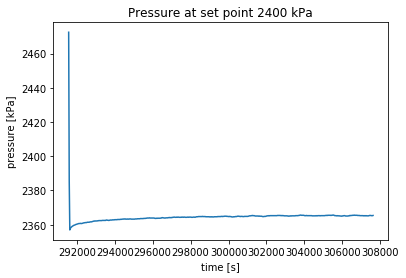

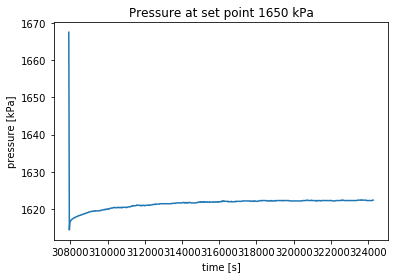

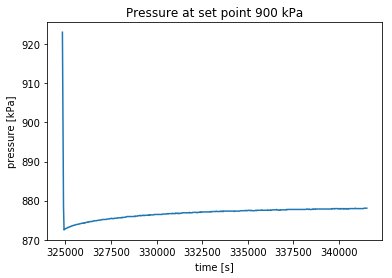

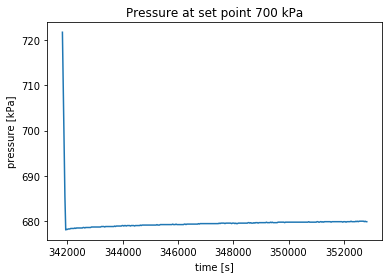

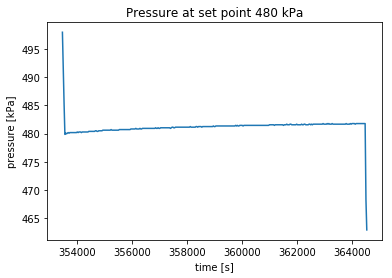

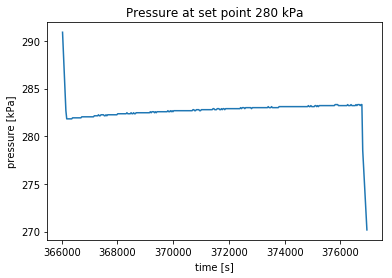

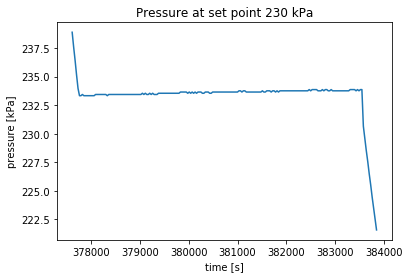

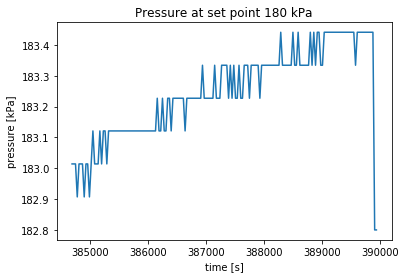

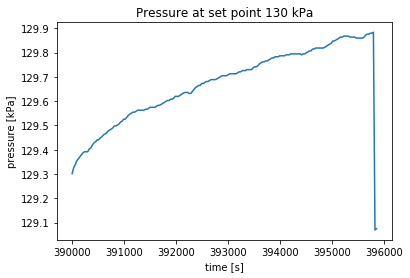

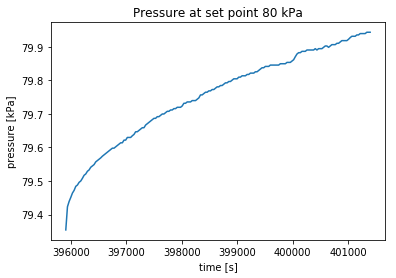

In [29]:
# initalize marker for pressure bounds
last_bound = 0
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds 
    i_p, last_bound = dataproc.get_inds_for_curr_p(p_arr, p_set, p_thresh_frac, last_bound)
    
    # PLOT PRESSURE
    plt.figure()
    plt.plot(t_grav[i_p], p_arr[i_p])
    plt.xlabel('time [s]')
    plt.ylabel('pressure [kPa]')
    plt.title('Pressure at set point {0} kPa'.format(p_set))
    
    # store results in data frame
    df_meas = dataproc.store_grav_adsa(df_meas, i, i_p, t_grav, t_adsa, br_arr, bp_arr, if_tension, drop_vol, n_adsa)
    
# correct error in zero measurement at 130 kPa--2 measurements, -0.00218, -0.00217 [g]
df_meas['zero [g]'].loc[23] = -0.002175
df_meas['zero std [g]'].loc[23] = 0.00001

**We see above that the pressure spiked at 5500 kPa, which may explain the kink in the sorption curve that we see below.**

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, and specific volume. We begin with the solubility.

### Interfacial Tension

The interfacial tension measurements are performed using pendant drop analysis with the software FTA32. These results do not require further analysis beyond the averaging and standard deviation performed above.

#### Ad Hoc Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must comptue the mass and volume of the polymer under vacuum. For this experiment, I lost the image of the drop under vacuum, so I must estimate the mass and volume of the polyol under vacuum by extrapolating from atmospheric measurements of mass and density. However, since I don't have Rubotherm measurements at atmospheric pressure, I extrapolated the mass between the masses at 80 kPa and 130 kPa. I then estimated the volume by assuming the same mass density as at atmospheric pressure.

In [30]:
# Because I am missing a measurement of the volume of the drop in vacuum, I must estimate
# the mass of the dry polymer in the following ad hoc manner:

# balance readings at equilibrium 
br_eq = df_meas['mp1 [g]'].values - df_meas['zero [g]'].values
# (extract value at 0 pressure) [g]
br_eq_0 = br_eq[0]
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df_meas['dissolved gas balance reading [g]'] = br_gas

# sample volume at atmospheric pressure [mL]
v_samp_atm = w_samp_atm / rho_samp_atm
# buoyant force correction at 130 kPa (pressure step at index -2) [g]
buoyancy_130kPa = dataproc.rho_gas(p_set_arr[-2])*(v_samp_atm + v_ref_he)
br_gas_130kPa = br_gas[-2]
# weight of gas at 153 kPa (buoyancy-corrected) [g]
w_gas_130kPa = br_gas_130kPa + buoyancy_130kPa

# buoyant force correction at 80 kPa (pressure step at index -1) [g]
buoyancy_80kPa = dataproc.rho_gas(p_set_arr[-1])*(v_samp_atm + v_ref_he)
br_gas_80kPa = br_gas[-1]
# weight of gas at 80 kPa (buoyancy-corrected) [g]
w_gas_80kPa = br_gas_80kPa + buoyancy_80kPa

# APPROXIMATE weight of gas at atmosphere with linear interpolation [g]
w_gas_atm = w_gas_80kPa + (w_gas_130kPa - w_gas_80kPa)*(P_ATM - 80)/(130 - 80)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly = w_samp_atm - w_gas_atm
print('Dry polymer mass = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % (w_poly, w_samp_atm))
# APPROXIMATE volume of dry (vacuum) sample using density at atmospheric pressure [mL]
v_poly = w_poly / rho_samp_atm
print('Volume of dry polymer in crucible is ~ %3f mL.' % v_poly)

# print the tare (mass of crucible, hook, etc.). No buoyancy correction under vacuum
tare = br_eq_0 - w_poly - df_meas['zero [g]'][0]
print("tare = " + str(tare) + ' g.')

Dry polymer mass = 0.684540 g vs. mass of polymer at atmospheric pressure = 0.686000 g.
Volume of dry polymer in crucible is ~ 0.671117 mL.
tare = 7.282326873047169 g.


### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=0)}{V_{drop}(p=0)}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

In [31]:
# Drop volume [uL]
v_drop = df_meas['drop volume [uL]'].values
# # if initial drop volume is given, use it as the reference
# if v_drop_0_manual > 0:
#     v_drop_0 = v_drop_0_manual
# # otherwise, use the first measurement of the drop volume as the reference
# else:
#     v_drop_0 = v_drop[0]
# # estimate sample volume by assuming same volume change as drop (assume negligible effect of curvature) [mL]
# v_samp = v_drop / v_drop_0 * v_poly

# USE A BETTER HEURISTIC: estimate V_drop(p=p_atm) with p=153 kPa and use V_poly(p=p_atm) as sample ref
v_drop_130kPa = v_drop[-2]

v_samp = v_drop / v_drop_130kPa * v_samp_atm
df_meas['sample volume [mL]'] = v_samp

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
buoyancy = dataproc.rho_gas(p_set_arr)*(v_samp + v_ref_he)
df_meas['buoyancy correction [g]'] = buoyancy
w_gas_act = br_gas + buoyancy
df_meas['actual weight of dissolved gas [g]'] = w_gas_act
# calculate solubility w/w
df_meas['solubility'] = w_gas_act / (w_poly + w_gas_act)

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

Text(0,0.5,'specific volume [mL/g]')

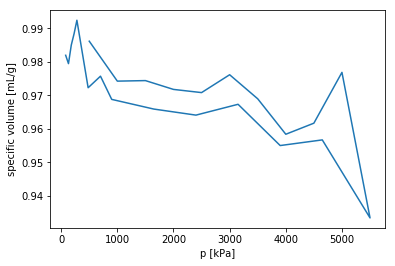

In [34]:
# calculate specific volume
df_meas['specific volume [mL/g]'] = v_samp / (w_gas_act + w_poly)

# save results
df_meas.to_csv(save_file_path)

# Plot specific volume vs. pressure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_meas['p [kPa]'].values, df_meas['specific volume [mL/g]'])
ax.set_xlabel('p [kPa]')
ax.set_ylabel('specific volume [mL/g]')

#### Plotting mass of absorbed gas over time

For visual analysis, we plot the absorption of gas over time alongside the pressure

Pressure = 0 kPa.
Pressure = 500 kPa.
Pressure = 1000 kPa.
Pressure = 1500 kPa.
Pressure = 2000 kPa.
Pressure = 2500 kPa.
Pressure = 3000 kPa.
Pressure = 3500 kPa.
Pressure = 4000 kPa.
Pressure = 4500 kPa.
Pressure = 5000 kPa.
Pressure = 5500 kPa.
Pressure = 4650 kPa.
Pressure = 3900 kPa.
Pressure = 3150 kPa.
Pressure = 2400 kPa.
Pressure = 1650 kPa.
Pressure = 900 kPa.
Pressure = 700 kPa.
Pressure = 480 kPa.
Pressure = 280 kPa.
Pressure = 230 kPa.
Pressure = 180 kPa.
Pressure = 130 kPa.
Pressure = 80 kPa.


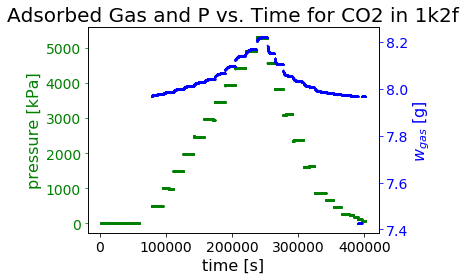

In [26]:
from scipy.signal import medfilt

# Set plot parameters
lw = 2
ax_fs = 16
t_fs = 20
tk_fs = 14
colors = ['g', 'b']
line_styles = ['--',  '-']
ms = 1
x_lim = [80000, 400000]
y_lim = [7.88, 7.9]

# initalize marker for pressure bounds
last_bound = 0
# initialize array to store p, t, and gas weight for plotting
w_gas_2_plot = np.array([])
p_2_plot = np.array([])
t_2_plot = np.array([])
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds 
    i_p, last_bound = dataproc.get_inds_for_curr_p(p_arr, p_set, p_thresh_frac, last_bound)
    # extract data for current pressure
    t_select = t_grav[i_p]
    br_select = br_arr[i_p]
    bp_select = bp_arr[i_p]
    p_select = p_arr[i_p]
    
    # extract mp1 measurements and corresponding times for the current pressure set point
    is_mp1 = (bp_select == 2)
    mp1 = medfilt(br_select[is_mp1], kernel_size=5) # medfilt removes spikes from unstable measurements
    t_mp1 = t_select[is_mp1]
    p_mp1 = p_select[is_mp1]
    # Is the sample adsorbing or desorbing gas?
    is_adsorbing = (p_set_arr[i] - p_set_arr[max(i-1,0)]) >= 0
    # Cut off data points at the beginning and end from the transition between pressure set points
    i_start, i_end = dataproc.get_mp1_interval(mp1, is_adsorbing)
    mp1 = mp1[i_start:i_end]
    t_mp1 = t_mp1[i_start:i_end]
    p_mp1 = p_mp1[i_start:i_end]

    # compute mass of adsorbed gas and append
    zero = df_meas['zero [g]'].iloc[i]
    buoyancy = df_meas['buoyancy correction [g]'].iloc[i]
    # compute actual gas mass by subtracting zero (tare) and correcting for buoyancy
    w_gas_act_curr = mp1 - zero + buoyancy
    
    # skip if data has nans
    if np.isnan(w_gas_act_curr.any()):
        continue
        
    # append data for plotting
    w_gas_2_plot = np.append(w_gas_2_plot, w_gas_act_curr)
    p_2_plot = np.append(p_2_plot, p_mp1)
    t_2_plot = np.append(t_2_plot, t_mp1)
    
# Plot adsorbed gas and pressure over time
# create plot for pressure
fig, ax1 = plt.subplots()
# plot pressure
ax1.plot(t_2_plot, p_2_plot, 'o', ms=ms, label='p', color=colors[0])
# labels
ax1.set_xlabel('time [s]', fontsize=ax_fs)
ax1.set_ylabel('pressure [kPa]', color=colors[0], fontsize=ax_fs)
ax1.tick_params('y', colors=colors[0])
ax1.set_title('Adsorbed Gas and P vs. Time for CO2 in 1k2f', fontsize=t_fs)

# separate axis for gas mass
ax2 = ax1.twinx()
# plot adsorbed gas mass
ax2.plot(t_2_plot, w_gas_2_plot, '^', ms=ms, label=r'$w_{gas}$', color=colors[1])
# labels
ax2.set_ylabel(r'$w_{gas}$ [g]', color=colors[1], fontsize=ax_fs)
ax2.tick_params('y', colors=colors[1])
# limits
# ax2.set_ylim(y_lim)
# ax2.set_xlim(x_lim)

# increase font size of tick labels
ax1.tick_params(axis='both', which='major', labelsize=tk_fs)
ax2.tick_params(axis='y', which='major', labelsize=tk_fs)
fig.tight_layout()

# save plot ?
# if len(save_plot_path) > 0 :
#     plt.savefig(save_plot_path, bbox_inches="tight")

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

Pressure = 0 kPa.
Pressure = 500 kPa.
t min = 50.333 and t max = 16700.333
w min = 0.001 and w max = 0.008
D_sqrt = 3.98e-07 cm^2/s.
t_init = 78480
t0_fit = 78459.66676440032
t0 = 59730
Pressure = 1000 kPa.
t min = 112.178 and t max = 15802.178
w min = 0.001 and w max = 0.012
D_sqrt = 2.58e-07 cm^2/s.
t_init = 95340
t0_fit = 95317.82189552982
t0 = 95220
Pressure = 1500 kPa.


C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:269: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


t min = 97.363 and t max = 14917.363
w min = 0.002 and w max = 0.013
D_sqrt = 1.50e-07 cm^2/s.
t_init = 111300
t0_fit = 111292.63696075708
t0 = 111210
Pressure = 2000 kPa.
t min = 86.239 and t max = 15206.239
w min = 0.002 and w max = 0.014
D_sqrt = 1.02e-07 cm^2/s.
t_init = 126390
t0_fit = 126393.76136577805
t0 = 126270
Pressure = 2500 kPa.
t min = 64.565 and t max = 15784.565
w min = 0.002 and w max = 0.015
D_sqrt = 7.53e-08 cm^2/s.
t_init = 141780
t0_fit = 141805.43519021422
t0 = 141690
Pressure = 3000 kPa.
t min = 64.143 and t max = 15784.143
w min = 0.002 and w max = 0.016
D_sqrt = 6.34e-08 cm^2/s.
t_init = 157800
t0_fit = 157825.8565509319
t0 = 157710
Pressure = 3500 kPa.
t min = 106.170 and t max = 15196.170
w min = 0.002 and w max = 0.017
D_sqrt = 5.95e-08 cm^2/s.
t_init = 173940
t0_fit = 173953.83033829203
t0 = 173730
Pressure = 4000 kPa.
t min = 47.859 and t max = 15137.859
w min = 0.002 and w max = 0.019
D_sqrt = 6.65e-08 cm^2/s.
t_init = 189360
t0_fit = 189432.14095838647
t

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


t min = 242205.957 and t max = 258045.957
w min = 3.034 and w max = 3.052
D_sqrt = 2.18e-05 cm^2/s.
t_init = 237210
t0_fit = -4755.957423986628
t0 = 237060
Pressure = 4650 kPa.
t min = 253503.802 and t max = 263943.802
w min = 7.682 and w max = 7.712
D_sqrt = 2.80e-04 cm^2/s.
t_init = 253440
t0_fit = 146.19824865292154
t0 = 253350
Pressure = 3900 kPa.
t min = 264277.694 and t max = 276817.694
w min = 5.811 and w max = 5.837
D_sqrt = 2.44e-04 cm^2/s.
t_init = 264240
t0_fit = 142.30569021743682
t0 = 264150
Pressure = 3150 kPa.
t min = 235.436 and t max = 14335.436
w min = 0.007 and w max = 0.031
D_sqrt = 5.25e-07 cm^2/s.
t_init = 277140
t0_fit = 277024.56371371186
t0 = 277020
Pressure = 2400 kPa.
t min = 109.369 and t max = 16009.369
w min = 0.003 and w max = 0.024
D_sqrt = 4.04e-07 cm^2/s.
t_init = 291570
t0_fit = 291580.6308093846
t0 = 291420
Pressure = 1650 kPa.
t min = 158.673 and t max = 16388.673
w min = 0.003 and w max = 0.022
D_sqrt = 7.18e-07 cm^2/s.
t_init = 307920
t0_fit = 307

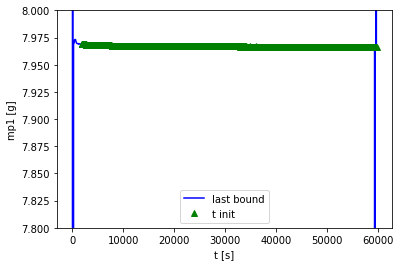

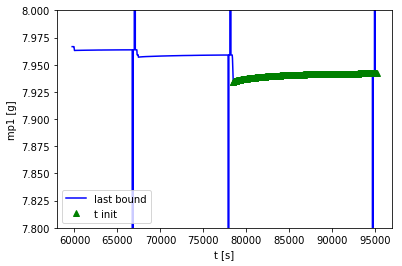

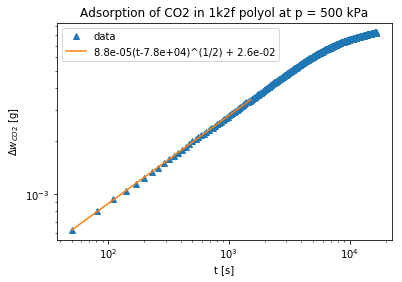

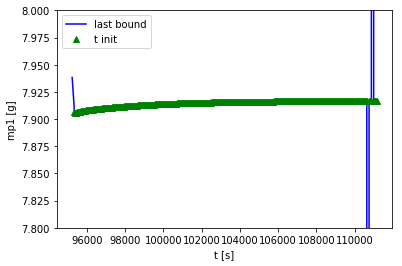

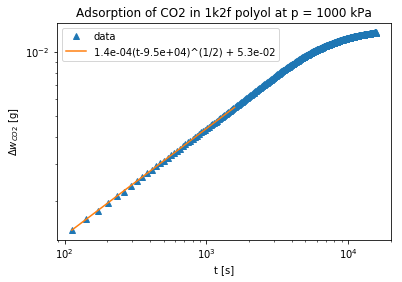

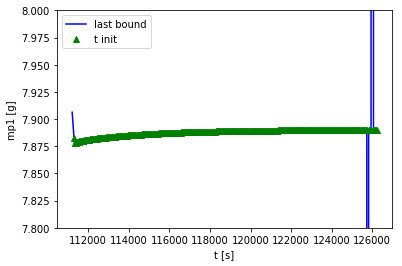

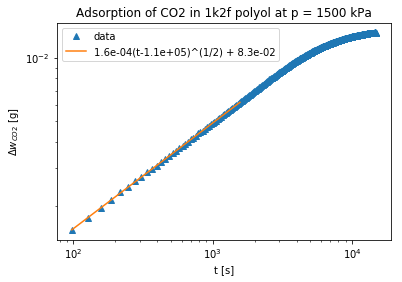

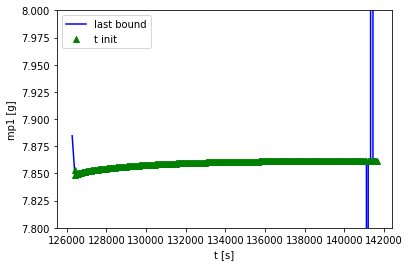

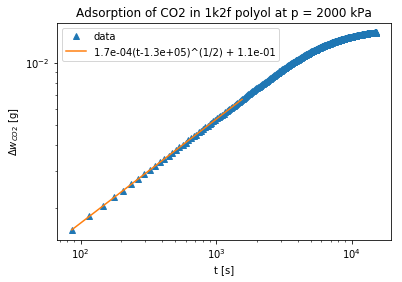

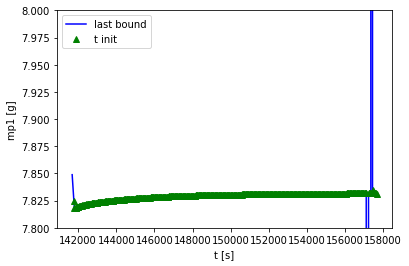

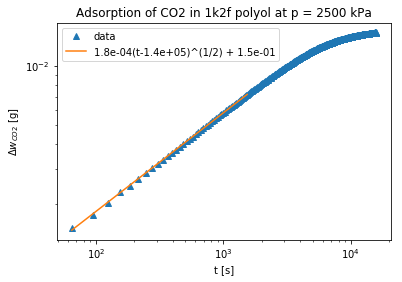

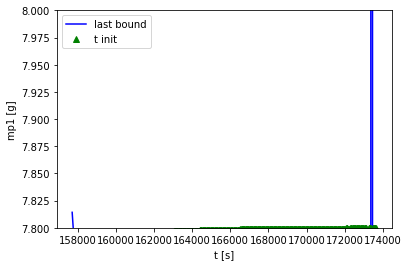

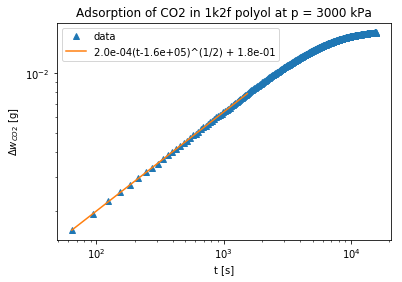

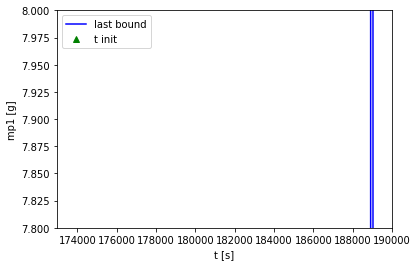

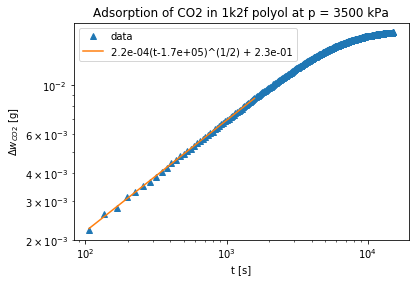

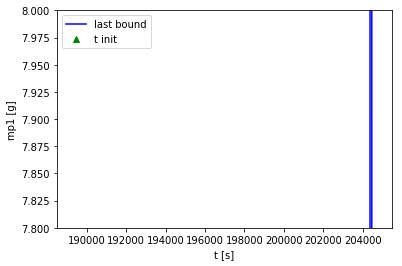

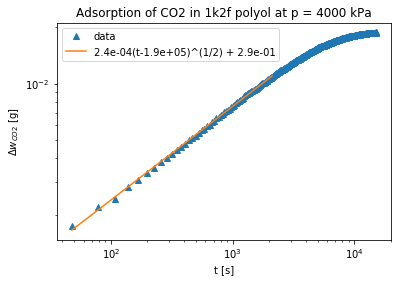

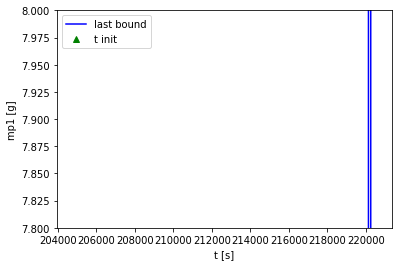

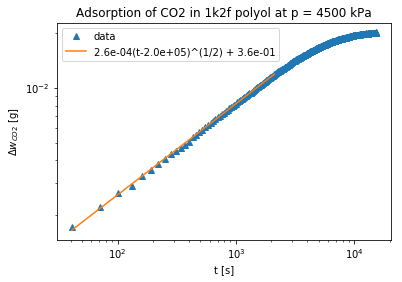

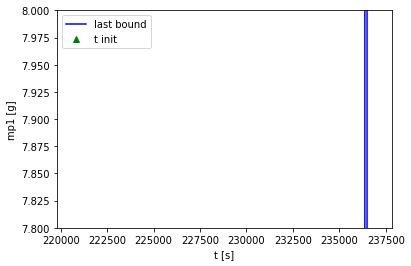

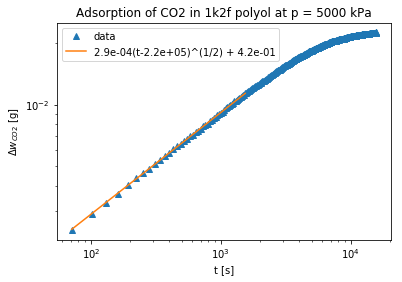

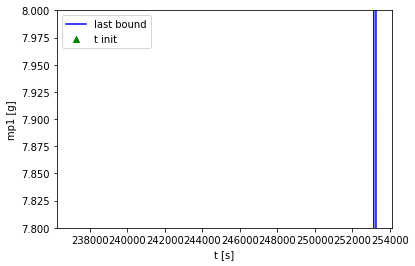

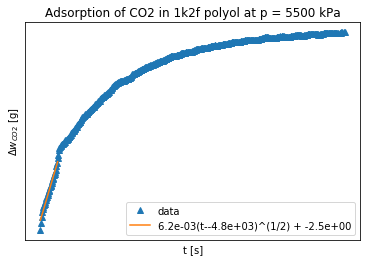

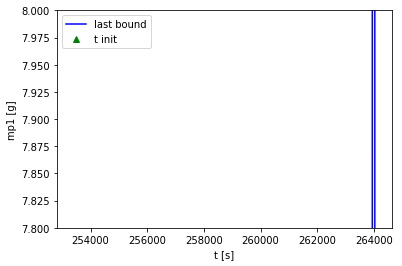

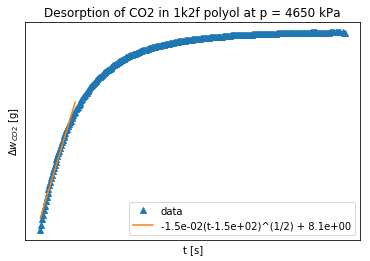

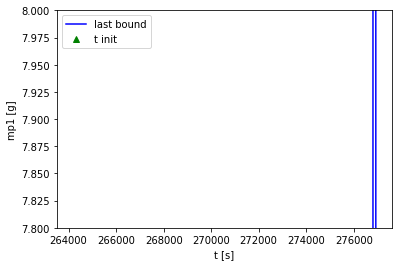

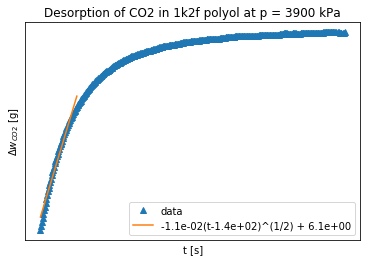

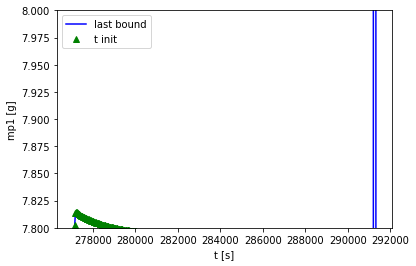

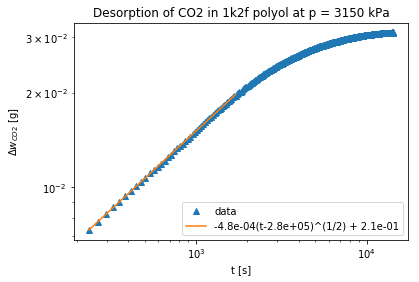

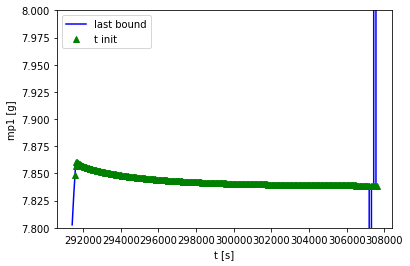

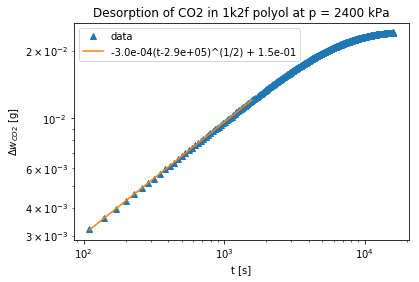

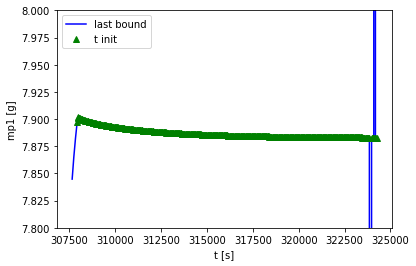

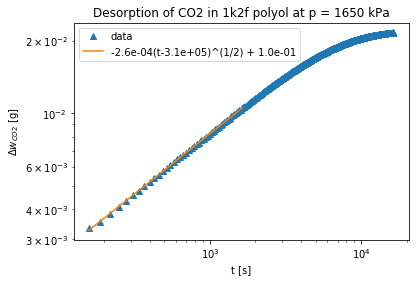

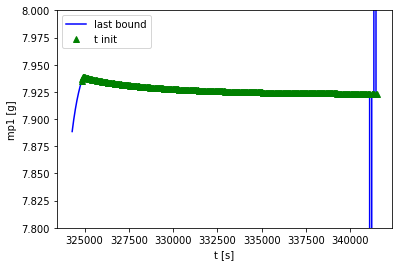

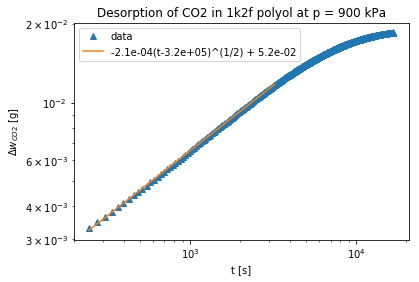

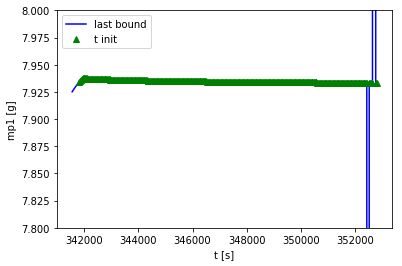

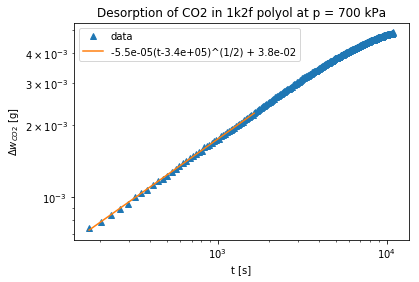

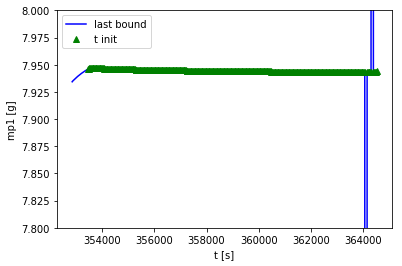

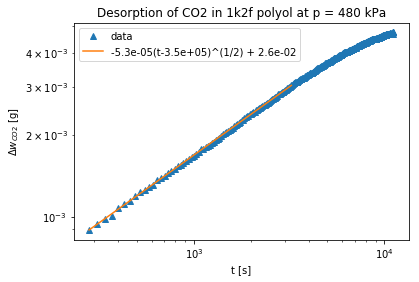

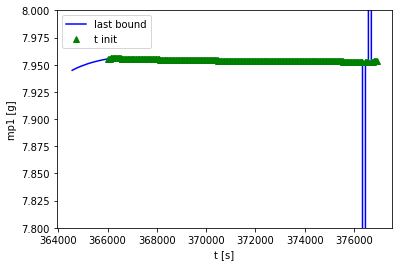

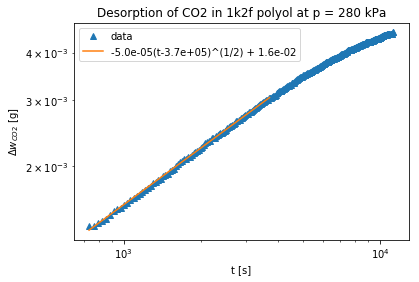

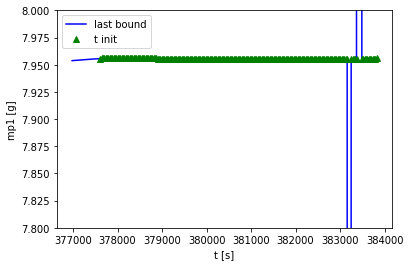

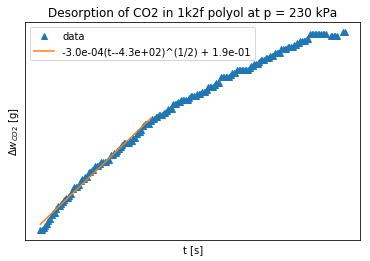

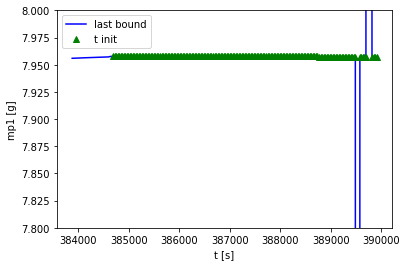

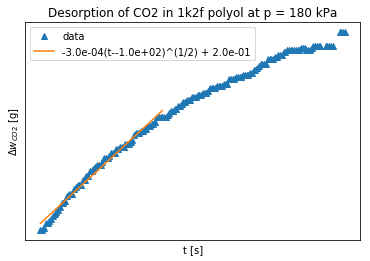

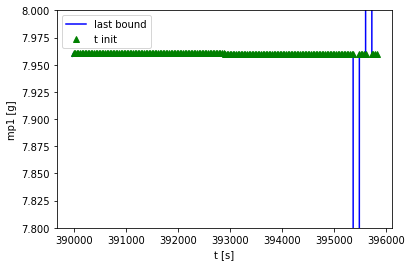

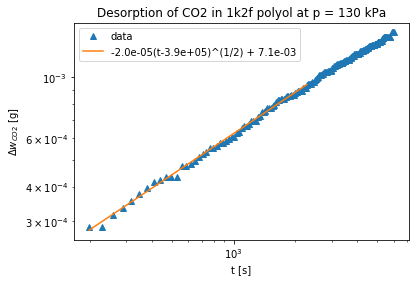

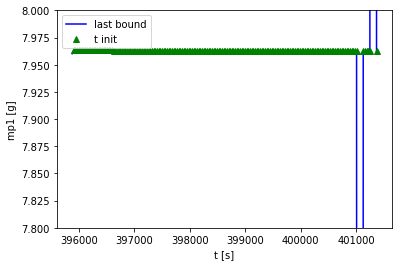

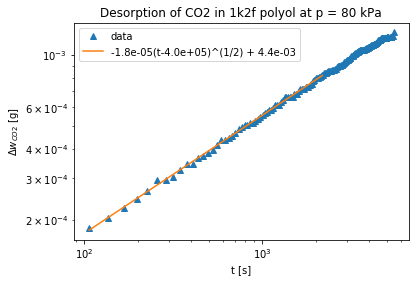

In [40]:
# NOTES
# p = 5500 kPa doesn't seem to be fit properly--should I try to refit with a different number of points (cut off before kink?)
# FOR REFERENCE
# p_set_arr = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
#                        5000, 5500, 4650, 3900, 3150, 2400, 1650, 900, 700, 480, 
#                        280, 230, 180, 130, 80])

# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones(len(p_set_arr)).astype(int)
n_pts_sqrt_arr[11] = 30
n_pts_sqrt_arr[8:10] = 70
n_pts_sqrt_arr[12] = 40
n_pts_sqrt_arr[13] = 50
n_pts_sqrt_arr[17] = 100
n_pts_sqrt_arr[19] = 100
n_pts_sqrt_arr[20] = 100
n_pts_sqrt_arr[21] = 70
n_pts_sqrt_arr[22] = 70
n_pts_sqrt_arr[23] = 70
n_pts_sqrt_arr[24] = 70
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.zeros(len(p_set_arr)).astype(int)
i_shift[2:7] = 2
i_shift[7:10] = 3
i_shift[11:14] = 3

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store extrapolated initial mass M_0
M_0_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # get indices of each measurement with pressure within thresholds 
    i_p, _ = dataproc.get_inds_for_curr_p(p_arr, p_set, p_thresh_frac, last_bound)
    t_init = t_grav[i_p[0]]
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    t0 = t_grav[last_bound]
    
    plt.figure()
    plt.plot(t_grav[last_bound:i_p[-1]], br_arr[last_bound:i_p[-1]],'b', label='last bound')
    plt.plot(t_grav[i_p[0]:i_p[-1]], br_arr[i_p[0]:i_p[-1]],'g^', label='t init')
    plt.xlabel('t [s]')
    plt.ylabel('mp1 [g]')
    plt.ylim([7.8, 8])
    plt.legend(loc='best')

    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df_meas, last_bound, is_adsorbing = dataproc.compute_gas_mass(i, p_arr, p_set_arr, df_meas, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_3param, t_mp1[:n], w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    t0_fit = popt[2]
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100)
    w_fit = dataproc.square_root_3param(t_fit, a, w0, t0_fit)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0_fit, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit - t0_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0_fit))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa' % p_set)
    plt.legend(loc='best')

    print('t min = {0:.3f} and t max = {1:.3f}'.format(np.min(t_mp1 - t0_fit), np.max(t_mp1 - t0_fit)))
    print('w min = {0:.3f} and w max = {1:.3f}'.format(np.min(sign*(w_gas_act - w0)), np.max(sign*(w_gas_act - w0))))
    
    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df_meas)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_arr[i] = dataproc.square_root_3param(max(t_init, t0_fit), a, w0, t0_fit)
    print('t_init = ' + str(t_init))
    print('t0_fit = ' + str(t0_fit))
    print('t0 = ' + str(t0))
    

#     # try a 1-parameter fit...always fails so far
#     try:
#         # really should use the beginning of the pressure change as point of t0 (indicated by the 'last_bound')
#         t0 = t_grav[last_bound]
#         # shift time and mass
#         t_rel = t_mp1 - t0
#         w_gas_act_0 = dataproc.square_root_3param(t0, a, b, t0_fit)
#         w_rel = w_gas_act - w_gas_act_0
#         # refit the shifted data
#         popt, pcov = curve_fit(dataproc.square_root_1param, t_rel, w_rel, maxfev=maxfev, p0=0.0001)
#         a1 = popt[0]
#         # generate t^(1/2) fit
#         t_fit1 = np.linspace(0, t_rel[-1], 100)
#         w_fit1 = dataproc.square_root_growth(t_fit1, a1)
#         # plot the result on a loglog plot (?)
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#         ax.plot(t_rel, w_rel, '^', label='data')
#         ax.plot(t_fit1, w_fit1, '-', label='%.1e t^(1/2)' % a1)
#         ax.set_xlabel('t [s]')
#         ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
#         if is_adsorbing:
#             stage = 'Adsorption'
#         else:
#             stage = 'Desorption'
#         ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa - 1 param fit' % p_set)
#         plt.legend(loc='best')
#     except:
#         print('1 param fit failed.')

Having computed the mean diffusivities, we will save them.

In [30]:
# record diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
df_meas['mean diffusivity (sqrt) [cm^2/s]'] = D_sqrt_arr
# record "initial" mass extrapolated to be at beginning of pressure quench
df_meas['M_0 [g]'] = M_0_arr

# save results
df_meas.to_csv(save_file_path)

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

***DEMONSTRATE THAT CHANGE IN H_SAMP IS NEGLIGIBLE (HOW SMALL?)***

Pressure = 0 kPa.
Pressure = 500 kPa.
D_exp = 6.68e-06 cm^2/s.
Pressure = 1000 kPa.
D_exp = 5.34e-06 cm^2/s.
Pressure = 1500 kPa.
D_exp = 9.09e-06 cm^2/s.
Pressure = 2000 kPa.
D_exp = 7.75e-09 cm^2/s.
Pressure = 2500 kPa.
D_exp = 3.63e-06 cm^2/s.
Pressure = 3000 kPa.
D_exp = 8.73e-06 cm^2/s.
Pressure = 3500 kPa.
D_exp = 4.93e-05 cm^2/s.
Pressure = 4000 kPa.
D_exp = 9.94e-09 cm^2/s.
Pressure = 4500 kPa.
D_exp = 1.48e-05 cm^2/s.
Pressure = 5000 kPa.
D_exp = 6.26e-05 cm^2/s.
Pressure = 5500 kPa.
D_exp = 2.96e-05 cm^2/s.
Pressure = 4650 kPa.
D_exp = 7.22e-05 cm^2/s.
Pressure = 3900 kPa.
D_exp = 9.33e-02 cm^2/s.
Pressure = 3150 kPa.


C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


D_exp = 1.68e-05 cm^2/s.
Pressure = 2400 kPa.
D_exp = 7.51e-06 cm^2/s.
Pressure = 1650 kPa.
D_exp = 7.16e-06 cm^2/s.
Pressure = 900 kPa.
D_exp = 7.83e-06 cm^2/s.
Pressure = 700 kPa.
D_exp = 8.21e-06 cm^2/s.
Pressure = 480 kPa.
D_exp = 7.12e-06 cm^2/s.
Pressure = 280 kPa.
D_exp = 5.75e-06 cm^2/s.
Pressure = 230 kPa.
D_exp = 8.86e-06 cm^2/s.
Pressure = 180 kPa.
D_exp = 7.49e-06 cm^2/s.
Pressure = 130 kPa.
D_exp = 2.63e-06 cm^2/s.
Pressure = 80 kPa.
D_exp = 8.76e-06 cm^2/s.


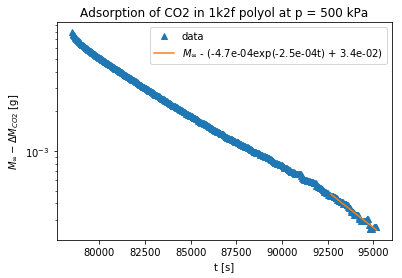

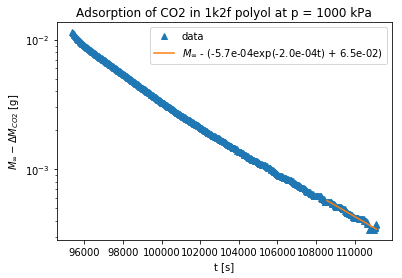

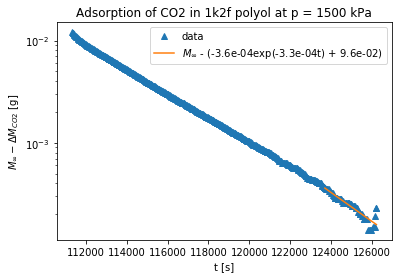

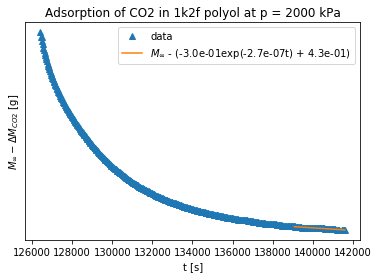

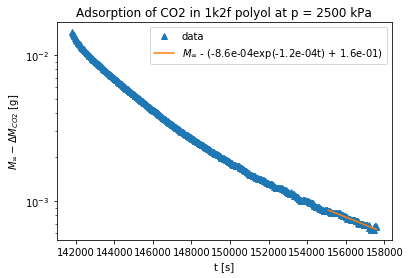

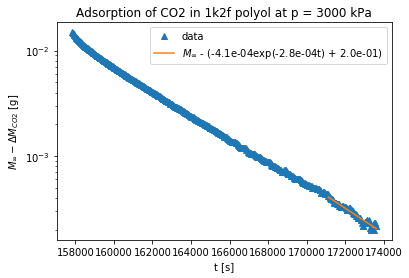

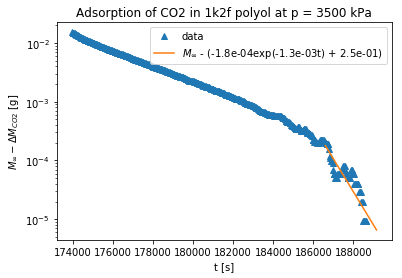

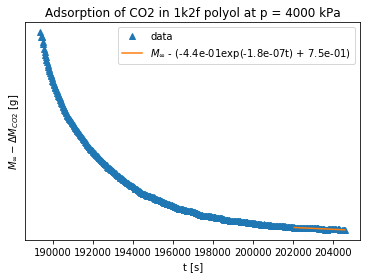

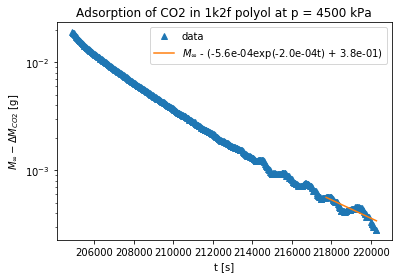

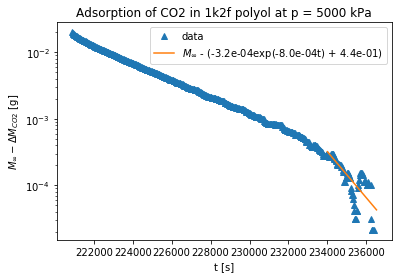

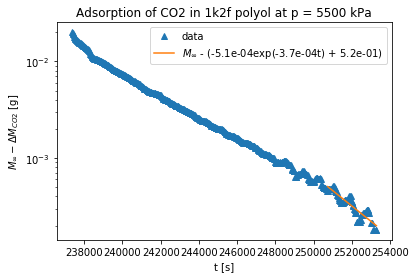

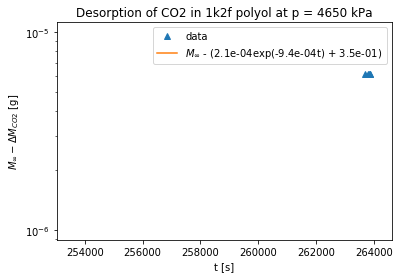

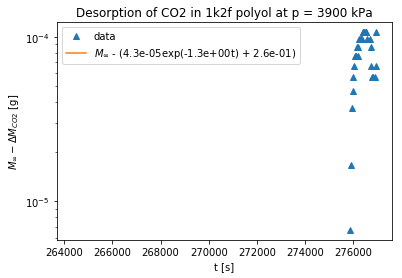

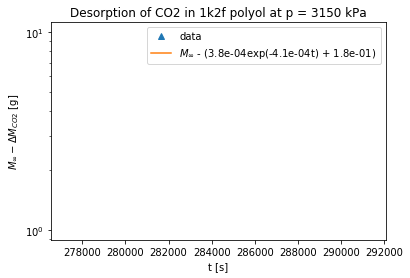

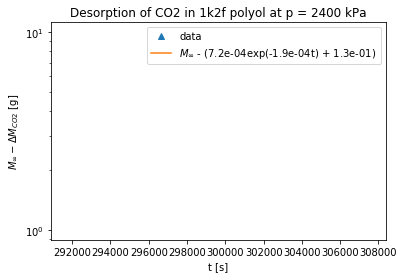

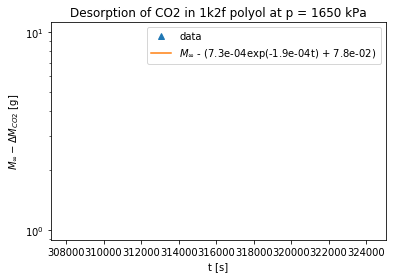

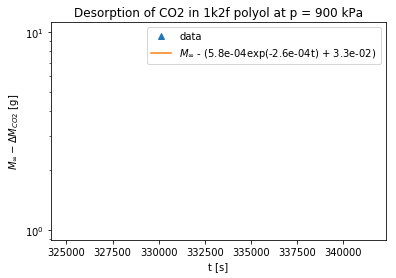

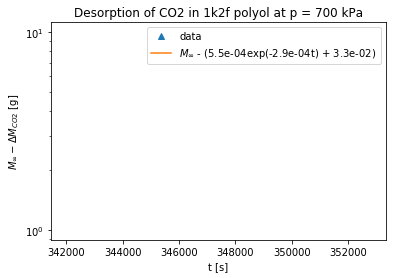

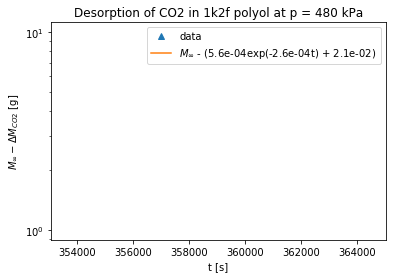

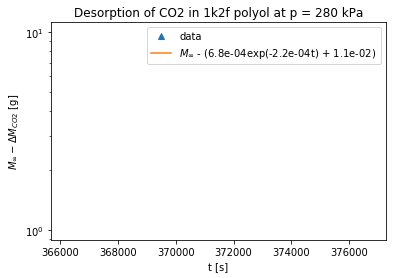

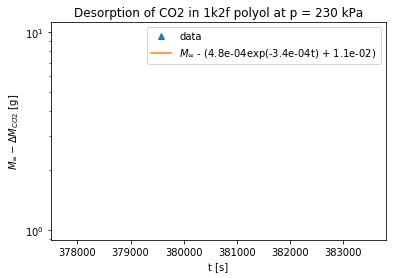

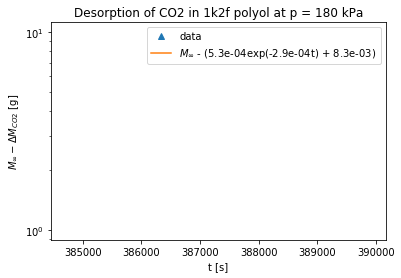

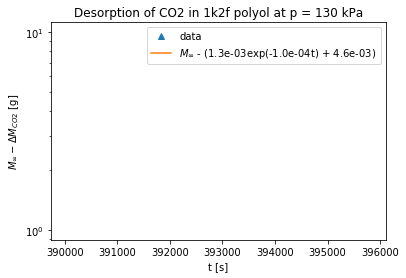

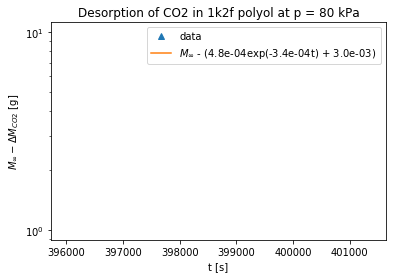

In [36]:
# initalize marker for pressure bounds
last_bound = 0
# set number of points for exponential fit
n_pts_exp = 80
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df_meas, last_bound, is_adsorbing = dataproc.compute_gas_mass(i, p_arr, p_set_arr, df_meas, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[-n_pts_exp:]-t_mp1[-n_pts_exp], w_gas_act[-n_pts_exp:], maxfev=maxfev, 
                           p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[-n_pts_exp], t_mp1[-1], 100) - t_mp1[-n_pts_exp]
    w_fit = dataproc.exponential_approach(t_fit, a, b, c)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy(t_mp1, c - w_gas_act, '^', label='data')
    ax.semilogy(t_fit + t_mp1[-n_pts_exp], c - w_fit, '-', label=r'$M_{\infty}$' + ' - ({a:.1e}exp({b:.1e}t) + {c:.1e})'.format(a=a, b=b, c=c))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$M_{\infty} - \Delta M_{CO2}$ [g]')
    ax.tick_params(axis='y', which='minor', left=True)
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa' % p_set)
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df_meas, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp
    
    # Store mass estimated at time --> infinity
    M_infty_arr[i] = c
    # store fitted exponential time constant [s]
    tau_arr[i] = -1/b

Having computed the mean diffusivities, we will save them.

In [35]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df_meas['mean diffusivity (exp) [cm^2/s]'] = D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df_meas['M_infty [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df_meas['tau [s]'] = tau_arr

# save results
df_meas.to_csv(save_file_path)